# INF200 Lecture No 10

### 14 November 2022

## Today's topics

1. Some advanced Python concepts
    1. Factories and closures
    1. Decorators and memoization
    1. Properties
    1. Iterators and generators
1. Generating Data / Scientific Computing
    1. SymPy: Symbolic Algebra with Python
    1. Limits of numerical precision
    1. SciPy: A Scientific Python package

--------

# Some advanced Python concepts

## Factories and closures

### Factory

- A function producing other functions (or classes, or objects)

In [1]:
def make_multiplier(factor):
    
    def multiplier(n):
        return factor * n
    
    return multiplier

doubler = make_multiplier(2)
tripler = make_multiplier(3)

factor = 10

print(doubler(2), doubler(5), doubler('a'))
print(tripler(2), tripler(5), tripler('a'))

4 10 aa
6 15 aaa


- Function `multiplier(n)` is defined *inside* `make_multiplier`
- The variable `factor` inside `multiplier(n)` is bound *when the function definition is executed*
- Therefore, we get `multiplier` functions with different values of `factor`
- Shows up in function representation as `<locals>` dictionary
    - local variables in factory class at time when `multiplier` was defined

In [2]:
doubler

<function __main__.make_multiplier.<locals>.multiplier(n)>

### Closure
- Here, `__main__.multiplier_factory.<locals>.multiplier` forms a *closure*
- `<locals>` stores variables bound in the environment in which `multiplier` was defined
- Generally: A closure binds free variables in a function to the value to which the name was bound when the function was defined, i.e., when the closure was created
- See also <a href="https://en.wikipedia.org/wiki/Closure_(computer_programming)">Wikipedia article on Closure</a>

#### Example

##### Function with free variable without closure

- Note: in the definition below, `foo` is not bound, it is a *free* variable

In [3]:
def f_open(x):
    return foo * x

- We cannot use `f_open()` unless `foo` is defined somewhere
- When executed, it will use the most local `foo` value available
- Can lead to difficult to predict results

In [4]:
f_open(10)

NameError: name 'foo' is not defined

In [5]:
foo = 5
f_open(10)

50

In [6]:
def g(y):
    foo = 100
    return f_open(y)

foo = 7
g(3)

21

- Why does `foo = 7` apply from global namespace, not `foo = 100` from local namespace in `g()`?
- Python (and many other programming languages) use <a href="https://en.wikipedia.org/wiki/Scope_(computer_science)#Lexical_scoping">*lexical scoping*</a>: name lookup is determined by where a function is *defined* in the program text, not where it is used
- In this example:
    - `f_open()` is defined at the module (notebook) level
    - therefore, any name not in the local namespace is looked up in the global namespace
        
##### Function with free variable with closure

- In definition below, `foo` is free in `f_func` itself
- By defining `f_func` inside another function, here `f_factory`, `foo` in `f_func` is bound to the `foo` argument of `f_factory` forming a closure

In [7]:
def f_factory(foo):
    def f_func(x):
        return foo * x
    return f_func

f3 = f_factory(3)
f8 = f_factory(8)

f3(9), f8(9)

(27, 72)

[Code in Pythontutor](https://pythontutor.com/visualize.html#code=def%20f_factory%28foo%29%3A%0A%20%20%20%20def%20f_func%28x%29%3A%0A%20%20%20%20%20%20%20%20return%20foo%20*%20x%0A%20%20%20%20return%20f_func%0A%0Af3%20%3D%20f_factory%283%29%0Af8%20%3D%20f_factory%288%29%0Aprint%28f3%289%29,%20f8%289%29%29%0A&cumulative=false&curInstr=18&heapPrimitives=nevernest&mode=display&origin=opt-frontend.js&py=3&rawInputLstJSON=%5B%5D&textReferences=false)

--------------------

## Decorators and Memoization

- Often useful to equip classes, functions or methods with extra functionality
- Can be wrapped around methods or functions
- Example: print state if debug mode is active
- [Fibonacci numbers](https://en.wikipedia.org/wiki/Fibonacci_number)
$$F_n = F_{n-1}+F_{n-2}\;, F_1 = 1,\; F_2 = 1$$

In [53]:
def fib(n):
    if n <= 2:
        return 1
    else:
        return fib(n-1) + fib(n-2)

In [54]:
fib(5)

5

- Would like to see recursive calls
- Do not want to insert print statements into code
- Wrap printing around functions!

In [21]:
def show_args(*args, **kwargs):
    print(args)
    print(kwargs)

In [22]:
show_args(5)

(5,)
{}


In [57]:
show_args(5, 6, 'a', foo=25, t=10)

(5, 6, 'a')
{'foo': 25, 't': 10}


In [58]:
def show_steps(func):
    
    def wrapped_func(*args, **kwargs):

        print('Args:', *args, **kwargs)

        res = func(*args, **kwargs)

        print('Res :', res)

        return res
    
    return wrapped_func

In [59]:
fib = show_steps(fib)

In [60]:
fib(4)

Args: 4
Args: 4
Args: 3
Args: 3
Args: 2
Args: 2
Res : 1
Res : 1
Args: 1
Args: 1
Res : 1
Res : 1
Res : 2
Res : 2
Args: 2
Args: 2
Res : 1
Res : 1
Res : 3
Res : 3


3

- Tidier: Use decorator notation

In [28]:
@show_steps
def fib(n):
    if n <= 2:
        return 1
    else:
        return fib(n-1) + fib(n-2)

In [29]:
fib(4)

Args: 4 {}
Args: 3 {}
Args: 2 {}
Res : 1
Args: 1 {}
Res : 1
Res : 2
Args: 2 {}
Res : 1
Res : 3


3

In [30]:
fib(6)

Args: 6 {}
Args: 5 {}
Args: 4 {}
Args: 3 {}
Args: 2 {}
Res : 1
Args: 1 {}
Res : 1
Res : 2
Args: 2 {}
Res : 1
Res : 3
Args: 3 {}
Args: 2 {}
Res : 1
Args: 1 {}
Res : 1
Res : 2
Res : 5
Args: 4 {}
Args: 3 {}
Args: 2 {}
Res : 1
Args: 1 {}
Res : 1
Res : 2
Args: 2 {}
Res : 1
Res : 3
Res : 8


8

### Application: Memoize functions

- `fib()` for large arguments means many repeated calls with same argument
- Eliminate by storing values we have seen before
- Called *memoization*
- Can be implemented using closure

#### "Manual" implementation

In [31]:
def memoize(func):
    _memo = {}

    def wrapped(arg):
        if arg not in _memo:
            _memo[arg] = func(arg)
        return _memo[arg]
    
    return wrapped

**NOTE: Cells below must be executed in order!**

##### Original function, not memoized

In [32]:
def memo_fib(n):
    if n < 2:
        return 1
    else:
        return memo_fib(n-1) + memo_fib(n-2)

In [33]:
memo_fib

<function __main__.memo_fib(n)>

##### Wrap function with memoize, obtain a closure

- Note that we must assign to same name again because of recursion!

In [34]:
memo_fib = memoize(memo_fib)

In [35]:
memo_fib

<function __main__.memoize.<locals>.wrapped(arg)>

##### Test on slightly larger n

In [36]:
memo_fib(35)

14930352

In [37]:
memo_fib(100)

573147844013817084101

##### For comparison using a version without memoization

In [38]:
def plain_fib(n):
    if n < 2:
        return 1
    else:
        return plain_fib(n-1) + plain_fib(n-2)

plain_fib(35)

14930352

- Significantly slower!

#### The same using memoize as decorator

In [39]:
@memoize
def fib(n):
    if n < 2:
        return 1
    else:
        return fib(n-1) + fib(n-2)

In [40]:
fib(200)

453973694165307953197296969697410619233826

- Shorter code
- No risk of unexpected results if cells are evaluated out-of-order (in Notebook)

## Properties

- OO Idea 2: Hide implementation details
- E.g., two different `Vector` implementations

```Python
class V:
    def __init__(self, x, y):
        self._x, self._y = x, y
    
class W:
    def __init__(self, x, y):
        self._c = [x, y]
```

- Problem
    - need accessor methods for coordinates
    - clumsy to use

```Python
    def get_x(self): return self._x
    def get_y(self): return self._y
    ...
    print v.get_x() + v.get_y()
```

- Solution: *Properties*
- Make accessor methods easily available
- In practice: 
    - define accessor methods
    - add methods as property to class using the Python `property()` function
- We only look at properties getting information
    - such read-only properties prevent that users change data
    - one can also implement properties that can be set
    - see [Python documentation for `property()`](https://docs.python.org/3/library/functions.html?highlight=property#property)

In [43]:
class W:
    def __init__(self, x, y):
        self._c = [x, y]
    def __repr__(self):
        return f'W({self.x}, {self.y})'

    def get_x(self): 
        return self._c[0]
    x = property(get_x)

    def get_y(self): 
        return self._c[1]
    y = property(get_y)

v = W(1, 2)
print(v.x)
print(v.y)
print(v)

1
2
W(1, 2)


In [44]:
v.x = 10

AttributeError: can't set attribute 'x'

#### Syntactic sugar: The property decorator

- *Syntactic sugar*: a way to express things "more nicely" without adding a new feature ("same stuff, nice wrapping")
- *Decorator*
    - a special type of function
    - name begins with `@`
    - modifies the definition following the decorator
- `@property` decorator makes it easy to create read-only properties

In [45]:
class W:
    def __init__(self, x, y):
        self._c = [x, y]
    def __repr__(self):
        return f'W({self.x}, {self.y})'

    @property
    def x(self): 
        return self._c[0]
    
    @property
    def y(self): 
        return self._c[1]

v = W(1, 2)
print(v.x, v.y)

1 2


#### More complex properties

- Can also provide values as properties that require more complex operations
- Example: polar representation of vector

In [46]:
import math

class V:
    def __init__(self, x, y):
        self._c = [x, y]
    def __repr__(self):
        return f'V({self.x}, {self.y})'

    @property
    def x(self): return self._c[0]
    
    @property
    def y(self): return self._c[1]
    
    @property
    def r(self): return math.sqrt(self.x**2+self.y**2)
    
    @property
    def phi(self): return math.atan2(self.x, self.y)

v = V(3, 4)
print(v.r, v.phi)

5.0 0.6435011087932844


#### Lazy evaluation

- Some properties may be expensive to compute
- In example above, if `r` or `phi` are used often, calculation repeated over and over again
- Could compute in constructor, but that costs if `r` and `phi` are never used
- Idea: compute only when needed, then retain
- Need to decide on most useful approach depending on use case

In [33]:
class V:
    def __init__(self, x, y):
        self._c = [x, y]
        self._r = None
        self._phi = None
        
    def __repr__(self):
        return f'V({self.x}, {self.y})'

    @property
    def x(self): return self._c[0]
    
    @property
    def y(self): return self._c[1]
    
    @property
    def r(self): 
        if self._r is None:
            self._r = math.sqrt(self._c[0]**2+self._c[1]**2)
        return self._r
    
    @property
    def phi(self): 
        if self._phi is None:
            self._phi = math.atan2(self._c[0], self._c[1])
        return self._phi

v = V(3, 4)
print(v.r, v.phi)

5.0 0.6435011087932844


----------------

## Iterators and Generators

- We commonly have data types containing elements that we access in sequence
    - elements of a list, characters of a string, lines in a file, ...
- Occasionally, we wan to generate numbers, permutations, etc, in sequence
    - Fibonacci numbers, card permutations, ...

### Basics

#### [Iterable](https://docs.python.org/3/glossary.html#term-iterable)

Any object that can be iterated over, i.e., and object that has elements or values that can be accessed in sequence.

#### [Iterator](https://docs.python.org/3/glossary.html#term-iterator)

An object that represents a stream of data, i.e., a sequence of elements or values.

##### Note
- In Python, every iterator is also an iterable, but not each iterable is an iterator.
- Example:
    - Each `list` is an iterable, but not an iterator
    - We can have multiple iterators for any given list
- See also
    - http://nvie.com/posts/iterators-vs-generators
    - https://www.python-course.eu/python3_generators.php
    - https://docs.python.org/3/howto/functional.html
    
### Working with iterators

- `iter(a)` provides us with an iterator for an iterable `a`
- `next(i)` returns the next value from the iterator `i`
- `StopIteration` exception is raise when no more values available

#### Example

In [61]:
cities = ['Oslo', 'Bergen', 'Trondheim', 'Tromsø']
c_it = iter(cities)
next(c_it)

'Oslo'

In [62]:
next(c_it)

'Bergen'

In [63]:
c_it_2 = iter(cities)

In [64]:
next(c_it), next(c_it_2)

('Trondheim', 'Oslo')

In [65]:
next(c_it), next(c_it_2)

('Tromsø', 'Bergen')

In [66]:
next(c_it)

StopIteration: 

#### How `for` really works

```python
for n in [11, 22, 33]:
  print(n)
```

1. calls `iter()` on list `[11, 22, 33]`
1. runs `n = next()` on  iterator
1. executes loop body
1. goto 2
1. exits when iterator raises `StopIteration`

In [67]:
iter(12)

TypeError: 'int' object is not iterable

### Defining an iterator

- An iterator is a class
- It must provide a `__next__()` method returning items in sequence
- `__next__()` must raise `StopIteration` when no more data available
- It must provide an `__iter__()` method returning itself (iterators are iterables)
- NB: iterables provide an `__iter__()` method that returns an interator object

#### Example: Stepping through a string letter by letter

In [68]:
class LetterIterator:
    def __init__(self, text):
        self._text = text
        self._pos = -1   # index of previous letter returned
        
    def __iter__(self):
        return self
    
    def __next__(self):
        self._pos += 1
        if self._pos >= len(self._text):
            raise StopIteration
        return self._text[self._pos]

In [69]:
li = LetterIterator('This is a test.')

In [70]:
next(li), next(li), next(li)

('T', 'h', 'i')

- The constructor stores the collection to iterator over (`_text`)
- The constructor keeps an index into the collection (`_pos`)
- `__next__()`
    - advances the iterator
    - terminates if string exhausted
    - returns next letter
    
##### Some test, especially corner cases

In [71]:
for c in LetterIterator('This is a test.'):
    print(c, end='_')

T_h_i_s_ _i_s_ _a_ _t_e_s_t_._

In [72]:
for c in LetterIterator(''):
    print(c, end='_')

In [73]:
for c in LetterIterator('T'):
    print(c, end='_')

T_

#### Example: Iterating by sentence

In [75]:
class SentenceIterator:
    def __init__(self, text):
        self._text = text
        self._pos = 0  # position of next letter to consider
        
    def __iter__(self):
        return self
    
    def __next__(self):
        start = self._pos
        while ( self._pos < len(self._text) 
                and self._text[self._pos] != '.' ):
            self._pos += 1
            
        if self._pos < len(self._text):
            self._pos += 1

        if start == self._pos:
            raise StopIteration
    
        return self._text[start:self._pos]

- Scan string until fullstop or end 
- If not at end, we must have left loop because of fullstop and need to increase `_pos` to include fullstop
- Terminate if nothing to return
- Return range of letters found

##### Some tests

In [76]:
for s in SentenceIterator('Sentence One. Sentence Two.'):
    print(s, end='#')

Sentence One.# Sentence Two.#

In [77]:
for s in SentenceIterator(''):
    print(s, end='#')

In [78]:
for s in SentenceIterator('T'):
    print(s, end='#')

T#

In [79]:
for s in SentenceIterator('.'):
    print(s, end='#')

.#

### Generators: Compact iterators

- Writing iterators requires a lot of "boilerplate" (typeskilt) code, i.e., code that is the same for each iterator
- *Generators* are similar to iterators, but Python does most of the work behind the scenes
- We only define a single function
- Using `yield` instead of `return` makes this a generator function

In [80]:
def SentenceGenerator(text):
    pos = 0
    while pos < len(text):
        start = pos
        while pos < len(text) and text[pos] != '.':
            pos += 1
        if pos < len(text):
            pos += 1   # last char was '.', need to include it
        if pos > start:
            yield text[start:pos]

In [81]:
g = SentenceGenerator('Ab. Cd.')

In [82]:
next(g)

'Ab.'

[Code on PythonTutor](https://pythontutor.com/render.html#code=def%20SentenceGenerator%28text%29%3A%0A%20%20%20%20pos%20%3D%200%0A%20%20%20%20while%20pos%20%3C%20len%28text%29%3A%0A%20%20%20%20%20%20%20%20start%20%3D%20pos%0A%20%20%20%20%20%20%20%20while%20pos%20%3C%20len%28text%29%20and%20text%5Bpos%5D%20!%3D%20'.'%3A%0A%20%20%20%20%20%20%20%20%20%20%20%20pos%20%2B%3D%201%0A%20%20%20%20%20%20%20%20if%20pos%20%3C%20len%28text%29%3A%0A%20%20%20%20%20%20%20%20%20%20%20%20pos%20%2B%3D%201%0A%20%20%20%20%20%20%20%20if%20pos%20%3E%20start%3A%0A%20%20%20%20%20%20%20%20%20%20%20%20yield%20text%5Bstart%3Apos%5D%0A%0Ag%20%3D%20SentenceGenerator%28'Ab.%20Cd.'%29%0A%0Anext%28g%29%0Anext%28g%29%0Anext%28g%29&cumulative=false&curInstr=0&heapPrimitives=nevernest&mode=display&origin=opt-frontend.js&py=3&rawInputLstJSON=%5B%5D&textReferences=false)

- `g` is generator object with `__next__()` method
- On first call to `__next__()`, code is executed from start of generator function up to and including `yield`
- `yield` returns value and execution stops (just as `return`)
- Generator *remembers* local variables `text`, `pos`, `start`
- On *next* and all further calls to `__next__()`, execution starts immediately after `yield` statement
- When execution reaches end of generator function, `StopIteration` is raised

In [83]:
next(g)

' Cd.'

In [84]:
next(g)

StopIteration: 

##### The same tests as for the `SentenceIterator`

In [85]:
for s in SentenceGenerator('Sentence One. Sentence Two.'):
    print(s, end='#')

Sentence One.# Sentence Two.#

In [86]:
for s in SentenceGenerator(''):
    print(s, end='#')

In [87]:
for s in SentenceGenerator('T'):
    print(s, end='#')

T#

In [88]:
for s in SentenceGenerator('.'):
    print(s, end='#')

.#

-----------

# Generating data / Scientific Python

- This course provides only a brief introduction to Scientific Python
- See especially [J. R. Johansson's book *Numerical Python*](https://jrjohansson.github.io/numericalpython.html)
    - Available for free as [eBook from NMBU network](https://link.springer.com/book/10.1007/978-1-4842-0553-2)
    - [Jupyter Notebooks for the book on Github](https://github.com/jrjohansson/numerical-python-book-code)
- See also 
    - J.R.Johanssons' [Introduction to Scientific Computing with Python](https://nbviewer.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)
    - [Python Scienctific Lecture Notes](https://scipy-lectures.github.io/) 


## Version information

- When working with scientific Python, we often use a large stack of packages
- Can be useful to freeze a set of package version using a [conda environment](https://conda.io/docs/user-guide/tasks/manage-environments.html)
- Important to keep track of which versions we are using

#### A little tool to display version information

In [89]:
import importlib

def show_versions(additional_modules=None):
    """
    Displays table of version numbers.
    
    :param additional_modules: Iterable with modules beyond default modules
    """

    modules = ['numpy', 'scipy', 'pandas', 'matplotlib']

    if additional_modules:
        modules += additional_modules
        
    for name in modules:
        try:
            mod = importlib.import_module(name)
        except ImportError:
            print(f'{name:12} module not available')
            continue
            
        try:    
            print(f'{name:12} {mod.__version__:8}')
        except AttributeError:
            print(f'{name:12} no version information')

In [90]:
show_versions()

numpy        1.22.3  
scipy        1.9.3   
pandas       1.4.4   
matplotlib   3.5.3   


In [91]:
show_versions(['seaborn', 'sympy', 'sklearn'])

numpy        1.22.3  
scipy        1.9.3   
pandas       1.4.4   
matplotlib   3.5.3   
seaborn      0.12.0  
sympy        1.10.1  
sklearn      1.1.3   


----------

## A *very* short introduction to SymPy

- [SymPy](http://www.sympy.org/en/index.html) provides *computer algebra* or *symbolic mathematics* in Python
- It allows you to perform *symbolic* manipulations on mathematical expressions (instead of *numerical* calculations)
- Examples based on SymPy documentation

In [92]:
import sympy
sympy.init_printing(use_latex=True)

### Simplify expressions

- Before we can use a variable name as a *symbolic* variable, we need to define it as such

In [93]:
x = sympy.symbols('x')

- We can then use the symbol in mathematical expressions

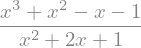

In [94]:
y = (x**3 + x**2 - x - 1)/(x**2 + 2*x + 1)
y

- And we can apply operations, e.g., simplification

In [95]:
sympy.simplify(y)

### Find the derivative of an expression

$$\frac{d}{dx} \sin(x) e^x$$

- When using mathematical functions in expressions, we need to take them from SymPy

In [96]:
f = sympy.sin(x) * sympy.exp(x)
f

In [97]:
df = sympy.diff(f, x)
df

### Find the integral of an expression

$$\int e^x\sin x + e^x \cos x dx$$

In [98]:
sympy.integrate(df, x)

### Solve equations

- By default, SymPy assumes that the expression should be zero

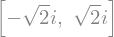

In [99]:
sympy.solve(x**2+2, x)

- If the right hand side is not zero, we need to use `Eq`

In [100]:
eq = sympy.Eq(x**2 + x, 3)
eq

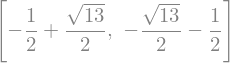

In [101]:
sympy.solve(eq, x)

- Using `solveset()` we can obtain all solutions

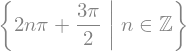

In [102]:
sympy.solveset(sympy.sin(x)+1, x)

### Some linear algebra

#### Define a matrix

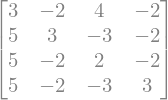

In [103]:
m = sympy.Matrix([[3, -2,  4, -2], 
                  [5,  3, -3, -2], 
                  [5, -2,  2, -2], 
                  [5, -2, -3,  3]])
m

#### Matrix-matrix multiplication

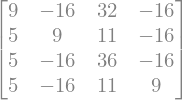

In [104]:
m * m

#### Inverse matrix

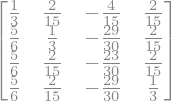

In [105]:
m_inv = m**(-1)
m_inv

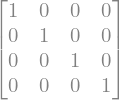

In [106]:
m * m_inv

#### Determinant

In [107]:
m.det()

#### Eigenvalues and eigenvectors

In [108]:
m.eigenvals()

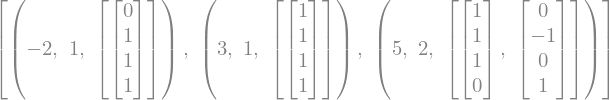

In [109]:
m.eigenvects()

In [110]:
sympy.init_printing(use_latex=False)

-------------------------

## Limits of numerical precision

- Computers represent floating point numbers with a fixed number of digits
- Most used today
    - 64-bit floating point numbers (aka "doubles")
    - 53-bit mantissa $\implies$ ca. 16 digits
    - smallest and largest numbers ca. $10^{-308}$ and $10^{308}$
    - details defined in [IEEE754 Standard for Floating-Point Arithmetic](https://en.wikipedia.org/wiki/IEEE_754)
- Machine learning often uses lower precision to gain performance

#### Example

In [111]:
import math

In [112]:
math.exp(math.log(5))

4.999999999999999

The numerical error in this case is

In [113]:
math.exp(math.log(5)) - 5

-8.881784197001252e-16

- This is $-8.8817841970012523\times 10^{-16}$
- Such errors are unavoidable and we need to handle them properly
- *Numerical mathematics* is a branch of mathematics that focuses on how to obtain reliable results efficiently even while working with limited precision

#### Machine precision `eps`

Machine precision is the smallest number for which `1 + x > 1` yields `True`.

In [85]:
x = 1.
while 1 + x > 1:
    x /= 2
print(2*x)

2.220446049250313e-16


- This is the typical machine precision for 64-bit floating point numbers with 53-bit mantissa.
- It is equal to 

In [114]:
2**-52

2.220446049250313e-16

### Critical cases

- Numerical precision is especially critical if we subtract 
- Assume $x\approx 1$, $y\approx 1$ and $x-y=10^{-10}$
    - Only 16 decimals for floats `x` and `y`
    - $\Longrightarrow$ only the first 6 decimals of `x-y` will be meaningful, the rest noise
- Possible solutions
    - Attempt to reformulate mathematical expressions
    - If possible, use suitable built in functions, e.g., `math.expm1(x)` to compute $e^x-1=x+\frac{x^2}{2!}+\frac{x^3}{3!}+\mathcal{O}(x^4)$
    - Carefully monitor results

In [115]:
import numpy as np
import matplotlib.pyplot as plt

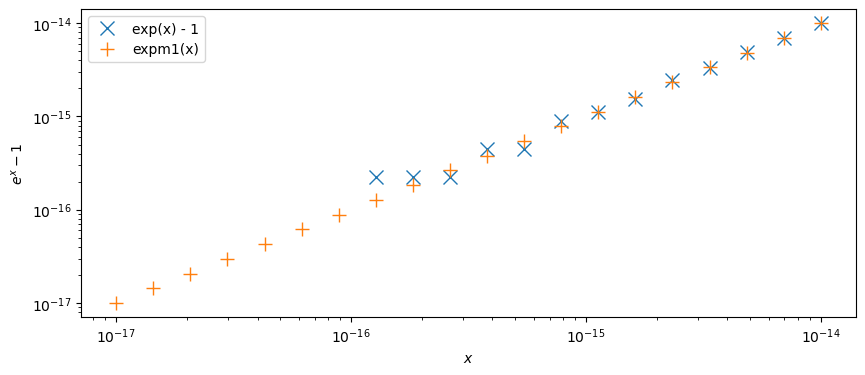

In [116]:
x = np.logspace(-17, -14, 20)
y_exp = np.exp(x) - 1
y_expm1 = np.expm1(x)
plt.figure(figsize=(10, 4))
plt.loglog(x, y_exp, 'x', label='exp(x) - 1', ms=10)
plt.loglog(x, y_expm1, '+', label='expm1(x)', ms=10)
plt.xlabel('$x$')
plt.ylabel('$e^x-1$')
plt.legend();

----------

## SciPy: A package for scientific computing with Python

- Builds on NumPy
- [User Guide](https://scipy.github.io/devdocs/tutorial/index.html#user-guide)
- Components
    - Special functions (scipy.special)
    - Integration (scipy.integrate)
    - Optimization (scipy.optimize)
    - Interpolation (scipy.interpolate)
    - Fourier Transforms (scipy.fft)
    - Signal Processing (scipy.signal)
    - Linear Algebra (scipy.linalg)
    - Sparse eigenvalue problems with ARPACK
    - Compressed Sparse Graph Routines (scipy.sparse.csgraph)
    - Spatial data structures and algorithms (scipy.spatial)
    - Statistics (scipy.stats)
    - Multidimensional image processing (scipy.ndimage)

### SciPy Example: Solving differential equations

- Simulate a three-body problem of "planets" moving according to Newton's laws
- For simplicity, we let the bodies move in the plane
- Each body is described completely by 
    - its mass $m_j$ (assumed constant)
    - its position ${\vec{r}}_j = (x_j, y_j)$
    - its velocity $\vec{v}_j = (v_{x, j}, v_{y, j})$
- The total force acting on each body is given by
$$
\vec{F}_j = -G \sum_{k\neq j} m_j \times m_k \times \frac{\vec{d}_{jk}}{\left|\vec{d}_{\!jk}\right|^3} \quad\text{with}\; \vec{d}_{jk}=\vec{r}_j-\vec{r}_k
$$
and [gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant) $G=6.674\cdot10^{−11} \mathrm{N}\mathrm{m}^2/\mathrm{kg}^2$
- The acceleration of a body is given by
$$
\vec{a}_j = \frac{\vec{F}_j}{m_j} = -G \sum_{k\neq j} \times m_k \times \frac{\vec{d}_{jk}}{\left(\vec{d}_{jk}^T\cdot\vec{d}_{jk}
\right)^\frac{3}{2}}
$$
- The change in position and velocity is given by
\begin{align}
\dot{\vec{v}}_ j &= \vec{a}_j \\
\dot{\vec{r}}_ j &= \vec{v}_j 
\end{align}
- This is a system of [ordinary differential equations (ODEs)](https://en.wikipedia.org/wiki/Ordinary_differential_equation)
- We consider and [initial value problem (IVP)](https://en.wikipedia.org/wiki/Initial_value_problem): planets in given positions at rest at time $t=0$

#### Implementation considerations

- SciPy supports integration of ODEs of the form
$$
\vec{y}'(t) = f(\vec{y}, t; \text{parameters})
$$
- $\vec{y}$ is the *state vector* describing the system
- We need to combine all positions and velocities into one vector $\vec{y}$
- Example: three bodies, two dimensions
    - six coordinates (x and y for each of three bodies)
    - six velocity components
    - $\vec{y}$ has 12 dimensions
      $$\vec{y}=\left(r_{1,x}, r_{1,y}, r_{2,x}, r_{2,y}, r_{3,x}, r_{3,y}, v_{1,x}, v_{1,y}, v_{2,x}, v_{2,y}, v_{3,x}, v_{3,y}\right)$$

In [117]:
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt

#### Function computing the derivative

- Form of function prescribed by [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html)
- Set gravitational constant to 1 for convenience
- We don't need the second (time) argument to `f()`, because our ODEs do not depend explicitly on time

In [118]:
G = 1        # gravitational constant
N_DIM = 2    # dimensions of space

def f(_, y, masses):
    n_bodies = len(masses)
    n_coords = n_bodies * N_DIM
    assert len(y) == 2 * n_coords, "y and masses inconsistent"
    
    # Build derivative vector dy with same shape as state vector y
    # y : First half are positions, second half velocities
    # dy: First half are velocities, second half accelerations
    dy = np.zeros_like(y)
    dy[:n_coords] = y[n_coords:]   # copy velocities from second half of y
    
    # Turn positions into matrix with one row per body and one column per dimension
    r = y[:n_coords].reshape(n_bodies, N_DIM) # positions
    a = np.zeros_like(r)   # accelerations, one row per body, one column per dim
    for body in range(n_bodies):
        for other_body in range(n_bodies):
            if other_body == body:
                continue
            # vector pointing from body to other_body
            d = r[other_body] - r[body]      
            
            # acceleration of body due to gravitational pull from other_body
            a[body, :] += (G * masses[other_body]
                           * d * (d.T @ d)**(-1.5))
    
    dy[n_coords:] = a.reshape(n_coords)   # accelerations: v' = a
    
    return dy

#### Euler integration

- Simplest ODE integration scheme
- Time discretized as $t_k = k \Delta t$
- Update rule
$$
\vec{y}_{k+1} = \vec{y}_k + \Delta t f(\vec{y}_k, t_k)
$$
- The function integrates the ODE from the given initial positions until tmax with time steps dt
- We assume initial velocities zero
- Returns three arrays:
    - positions `r[body, dim, time]`
    - velocities `v[body, dim, time]`
    - time

In [119]:
def planets_euler(masses, r0, dt, tmax):
    n_bodies, n_dim = r0.shape
    n_coords = n_bodies * n_dim

    t = np.arange(0., tmax, dt)
    npoints = len(t)

    y = np.zeros((2*n_coords, npoints))
    y[:n_coords, 0] = r0.reshape(n_coords)
    for n in range(npoints-1):
        y[:, n+1] = y[:, n] + dt * f(n*dt, y[:, n], masses)
        
    r = y[:n_coords, :].reshape((n_bodies, n_dim, -1))
    v = y[n_coords:, :].reshape((n_bodies, n_dim, -1))
    
    return r, v, t

#### Integration using `solve_ivp` from `scipy.integrate`

- Uses advanced ODE integration functions
- Automatically chooses times step
- Takes same input and returns same output as `planets_euler` except
    - no time step `dt`, because it is chosen automatically by solver
    - `**kwargs` allows us to pass extra arguments to solver
    - time values returned depend on solver

In [120]:
def planets_solve_ivp(masses, r0, tmax, **kwargs):
    n_bodies, n_dim = r0.shape
    n_coords = n_bodies * n_dim

    y0 = np.zeros(2 * n_coords)
    y0[:n_coords] = r0.reshape(n_coords)
    sol = scipy.integrate.solve_ivp(f, [0, tmax], y0, args=(masses,), **kwargs)
        
    r = sol.y[:n_coords, :].reshape((n_bodies, n_dim, -1))
    v = sol.y[n_coords:].reshape((n_bodies, n_dim, -1))
    
    return r, v, sol.t

#### Simulate example system

- Three bodies in 2-dimensional space
- So-called Pythagorean [three-body problem](https://en.wikipedia.org/wiki/Three-body_problem)
    - masses obey Pythagorean equality
    - initial locations form right triangle
    - masses originally at rest
- We use the Euler method and two methods offered by `solve_ivp`
    - [Runge-Kutta 4/5 method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (`RK45`, default)
    - Radau method (suitable for stiff systems)
- We run both methods with different error tolerances `rtol` (default $10^{-3}$)

In [121]:
masses = np.array([5., 3., 4.])
r0 = np.array([[1., -1.], [1., 3.], [-2., -1.]])

r_e, v_e, t_e = planets_euler(masses, r0, 0.001, 10)
r_rk45, v_rk45, t_rk45 = planets_solve_ivp(masses, r0, 10)
r_rk45_lt, v_rk45_lt, t_rk45_lt = planets_solve_ivp(masses, r0, 10, rtol=1e-10)
r_radau, v_radau, t_radau = planets_solve_ivp(masses, r0, 10, method='Radau')
r_radau_lt, v_radau_lt, t_radau_lt = planets_solve_ivp(masses, r0, 10, method='Radau', rtol=1e-10)

In [122]:
solutions = [(r_e, v_e, t_e, 'Euler'),
             (r_rk45, v_rk45, t_rk45, 'solve_ivp / RK45 ($rtol=10^{-3}$)'),
             (r_rk45_lt, v_rk45_lt, t_rk45_lt, 'solve_ivp / RK45 ($rtol=10^{-10}$)'),
             (r_radau, v_radau, t_radau, 'solve_ivp / Radau ($rtol=10^{-3}$)'),
             (r_radau_lt, v_radau_lt, t_radau_lt, 'solve_ivp / Radau ($rtol=10^{-10}$)')]

#### Plot motions in plane

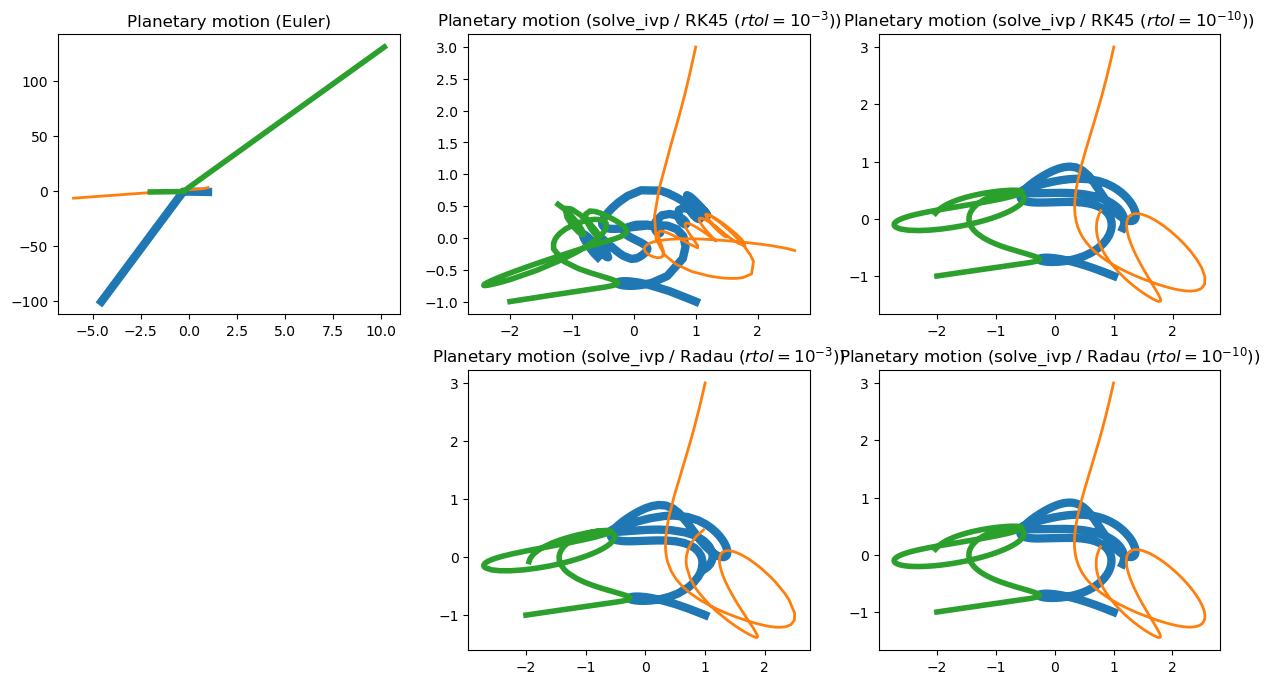

In [123]:
plt.figure(figsize=(15, 8))
figloc = [1, 2, 3, 5, 6]

for fignr, (r, _, _, method) in enumerate(solutions):    
    plt.subplot(2, 3, figloc[fignr])
    for ix, m in enumerate(masses):
        plt.plot(r[ix, 0,:], r[ix, 1, :], lw=2*(m-2))
    plt.title(f'Planetary motion ({method})');

- Signficantly different
- Which one is correct?

#### Calculation of total energy in systems

$$E_{\text{tot}} = E_{\text{kin}} + E_{\text{pot}} = \frac{1}{2}\sum_j m_j |\vec{v}_j|^2
  + G \sum_{k\neq j}  \frac{m_j \times m_k}{\left|\vec{r}_j-\vec{r}_k
\right|} = \text{const}$$

In [124]:
def total_energy(r, v, masses):
    n_bodies, n_dim, n_t = r.shape
    energy = np.zeros(n_t)
    
    for n in range(n_t):
        for body in range(n_bodies):
            
            # kinetic energy
            energy[n] = (0.5 * masses[body] 
                         * v[body, :, n].T @ v[body, :, n])

            # potential energy
            for other_body in range(n_bodies):
                if other_body == body:
                    continue
                d = r[other_body, :, n] - r[body, : , n]
                energy[n] += (G * masses[body] * masses[other_body]
                              * (d.T @ d)**(-0.5))
    
    return energy

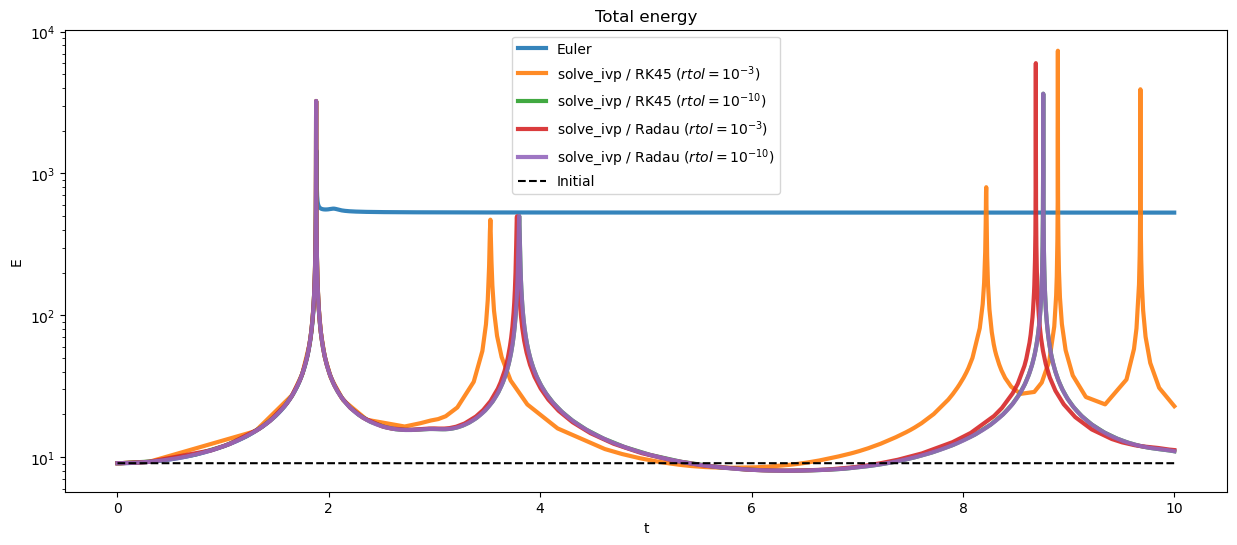

In [125]:
plt.figure(figsize=(15, 6))
for r, v, t, method in solutions:
    energy = total_energy(r, v, masses)
    plt.semilogy(t, energy, lw=3, alpha=0.9, label=method)
plt.semilogy(t, energy[0]*np.ones_like(t), 'k--', label='Initial')
plt.legend()
plt.title('Total energy')
plt.xlabel('t')
plt.ylabel('E');

- Euler is definitely wrong from first near-encounter on
- RK45 with tolerance $10^{-3}$ shows greater deviations and low time resolution
- RK45 and Radau coincide for tolerance $10^{-10}$
- The trajectories obtained with the latter approaches for $0\leq t \leq 10$ are visually consistent with the scientific literature (Fig 2 of [V. Szebehely and C. F. Peters, Astronom J 72:876–883, 1967](https://articles.adsabs.harvard.edu/pdf/1967AJ.....72..876S))
- We could use further conserved quantities for additional checks
    - center of mass
    - conservation of momentum and angular momentum
- We cannot trust our solutions for space navigation!
    - Better mathematical methods required to handle near encounters
- **Similar problems are even more challenging for systems for which we do not have conservation laws as tests!**